In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import torch 


(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc5a75ec7f0>)

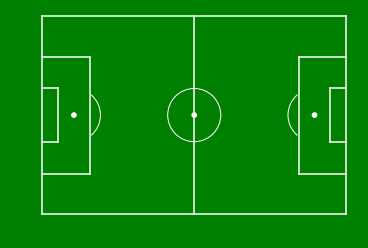

In [2]:
from matplotlib.patches import Arc


from cython.parallel import prange
import numpy as np
from scipy import stats
import time
import os
import pandas as pd

def matrix2vector(matrix):
    return matrix.flatten()

def vector2matrix(vector):
    return vector.reshape(68,105)

def surface_radius(px, py, bx, by):
    p = np.asarray((px,py))
    b = np.asarray((bx,by))
    d = np.linalg.norm(p-b)

    x4=2.56000000e-06
    x3=6.40000000e-05
    x2=1.60000000e-03 
    x1=4.00000000e-02 
    x0=8.00000000e+00
    
    rad = x4 * d**4 + x3 * d** 3 + x2 * d** 2 + x1 * d + x0 
    if rad > 25:
        rad = 25
    return rad

def player_influence2(px,py,bx, by, prex, prey):
    
    player = np.zeros((68,105))
    sx = (np.abs(px-prex)*25)**2
    sy = (np.abs(py-prey)*25)**2
    sxratio = sx**2/13**2
    syratio = sy**2/13**2
    radius = surface_radius(px,py,bx,by)
    sx_ = (radius + (radius * sxratio))/2
    sy_ = (radius - (radius * syratio))/2
    S = np.asarray([[sx_,0],[0,sy_]])
    theta = np.arctan2(prex - px, prey - py)
    R = np.asarray([[np.cos(theta),-1*np.sin(theta)],[np.sin(theta),np.cos(theta)]])
    COV = R*S*S*np.linalg.inv(R)
    
    # distribution mean value
    ux = px + sx*0.5
    uy = py + sy*0.5  

    x, y = np.mgrid[0:105,0:68]
    z = np.zeros([2,105,68])
    z[0] = x
    z[1] = y
    z = z.T    
    player = stats.multivariate_normal.pdf(z, mean=[ux,uy], cov=COV)
    player = player/ np.max(player) 
    return player

def  get_matrix(Px,Py, bx,by,prex,prey):
    matrix = np.zeros((68,105))
    
    for px,py,prex,prey  in zip(Px,Py, prex, prey):
        player = player_influence2(px, py, bx, by, prex,prey)
        matrix += np.nan_to_num(player)
    return matrix


def plot_pitch(height=68, width=105, xos=0, yofs=0):
    hscaler = 68 / height
    wscaler = 105 / width
    # Create figure
    fig = plt.figure(facecolor='green')
    ax = fig.add_subplot(1, 1, 1)
    
    ax.set_xlim([0,width])
    ax.set_ylim([0,height])
    
    color1 = 'white'
    center = (xos + width / 2, yofs + height / 2)

    # Pitch Outline & Centre Line
    plt.plot([xos, xos], [yofs, yofs + height], color=color1)
    plt.plot([xos, xos + width], [yofs + height, yofs + height], color=color1)
    plt.plot([xos + width, xos + width], [yofs + height, yofs], color=color1)
    plt.plot([xos + width, xos], [yofs, yofs], color=color1)
    plt.plot([xos + width / 2, xos + width / 2], [yofs, yofs + height], color=color1)

    # Left Penalty Area
    plt.plot([xos + 16.5 / wscaler, xos + 16.5 / wscaler],
             [yofs + height / 2 + 20.15 / hscaler, yofs + height / 2 - 20.15 / hscaler], color=color1)
    plt.plot([xos, xos + 16.5 / wscaler], [yofs + height / 2 + 20.15 / hscaler, yofs + height / 2 + 20.15 / hscaler],
             color=color1)
    plt.plot([xos + 16.5 / wscaler, xos], [yofs + height / 2 - 20.15 / hscaler, yofs + height / 2 - 20.15 / hscaler],
             color=color1)

    # Right Penalty Area
    plt.plot([xos + width - 16.5 / wscaler, xos + width - 16.5 / wscaler],
             [yofs + height / 2 + 20.15 / hscaler, yofs + height / 2 - 20.15 / hscaler], color=color1)
    plt.plot([xos + width, xos + width - 16.5 / wscaler],
             [yofs + height / 2 + 20.15 / hscaler, yofs + height / 2 + 20.15 / hscaler], color=color1)
    plt.plot([xos + width - 16.5 / wscaler, xos + width],
             [yofs + height / 2 - 20.15 / hscaler, yofs + height / 2 - 20.15 / hscaler], color=color1)

    # Left 6-yard Box
    plt.plot([xos + 5.5 / wscaler, xos + 5.5 / wscaler],
             [yofs + height / 2 + (7.32 / 2 + 5.5) / hscaler, yofs + height / 2 - (7.32 / 2 + 5.5) / hscaler],
             color=color1)
    plt.plot([xos, xos + 5.5 / wscaler],
             [yofs + height / 2 + (7.32 / 2 + 5.5) / hscaler, yofs + height / 2 + (7.32 / 2 + 5.5) / hscaler],
             color=color1)
    plt.plot([xos + 5.5 / wscaler, xos],
             [yofs + height / 2 - (7.32 / 2 + 5.5) / hscaler, yofs + height / 2 - (7.32 / 2 + 5.5) / hscaler],
             color=color1)

    # Right 6-yard Box
    plt.plot([xos + width - 5.5 / wscaler, xos + width - 5.5 / wscaler],
             [yofs + height / 2 + (7.32 / 2 + 5.5) / hscaler, yofs + height / 2 - (7.32 / 2 + 5.5) / hscaler],
             color=color1)
    plt.plot([xos + width, xos + width - 5.5 / wscaler],
             [yofs + height / 2 + (7.32 / 2 + 5.5) / hscaler, yofs + height / 2 + (7.32 / 2 + 5.5) / hscaler],
             color=color1)
    plt.plot([xos + width - 5.5 / wscaler, xos + width],
             [yofs + height / 2 - (7.32 / 2 + 5.5) / hscaler, yofs + height / 2 - (7.32 / 2 + 5.5) / hscaler],
             color=color1)

    #     # Prepare Circles
    centre_circle = plt.Circle(center, 9.15 / hscaler, color=color1, fill=False)
    centre_cspot = plt.Circle(center, 0.8 / hscaler, color=color1)
    left_pen_spot = plt.Circle((xos + 11 / wscaler, yofs + height / 2), 0.8, color=color1)
    right_pen_spot = plt.Circle((xos + width - 11 / wscaler, yofs + height / 2), 0.8, color=color1)

    #     # Draw Circles
    ax.add_patch(centre_circle)
    ax.add_patch(centre_cspot)
    ax.add_patch(left_pen_spot)
    ax.add_patch(right_pen_spot)

    #     # Prepare Arcs
    leftArc = Arc((xos + 11 / wscaler, yofs + height / 2), height=18.3 / hscaler, width=18.3 / wscaler, angle=0,
                  theta1=310, theta2=50, color=color1)
    rightArc = Arc((xos + width - 11 / wscaler, yofs + height / 2), height=18.3 / hscaler, width=18.3 / wscaler,
                   angle=0, theta1=130, theta2=230, color=color1)

    #     # Draw Arcs
    ax.add_patch(leftArc)
    ax.add_patch(rightArc)

    # Tidy Axes
    plt.axis('off')
    plt.xlim(0, width)
    plt.ylim(0, height)
    plt.autoscale(False)
    plt.axis('equal')

    # Display Pitch
    return fig, ax

plot_pitch()

In [3]:
import pandas as pd
df = pd.read_csv('sample.csv', index_col=0)
df.head()

df.tail()

,0,1_x,2_x,3_x,4_x,5_x,6_x,7,8,9,...,41,42,43,44,1_y,2_y,3_y,4_y,5_y,6_y
69774,2789.88,85.73,89.39,96.09,62.69,76.58,84.21,95.15,20.84,62.1,...,41.69,12.61,25.20,35.94,238.0,116.0,0.0,1.0,71.833333,29.333333
69775,2789.92,85.66,89.37,96.07,62.69,76.59,84.21,95.16,20.85,62.1,...,41.66,12.61,25.24,35.91,238.0,116.0,0.0,1.0,67.000000,30.500000
69776,2789.96,85.57,89.37,96.05,62.69,76.59,84.21,95.16,20.84,62.1,...,41.62,12.60,25.30,35.87,238.0,116.0,0.0,1.0,62.166667,31.666667
69777,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,238.0,116.0,0.0,1.0,57.333333,32.833333
69778,2790.08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,52.500000,34.000000


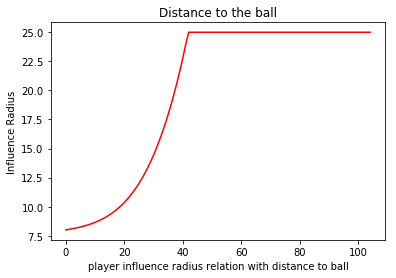

In [4]:
# player influence radius relation with distance to ball
def surface_radius(px,py,bx,by):
    p = (px,py)
    b = np.asarray((bx,by))
    d = np.linalg.norm(p-b)

    x4=2.56000000e-06
    x3=6.40000000e-05
    x2=1.60000000e-03 
    x1=4.00000000e-02 
    x0=8.00000000e+00
    
    rad = x4 * d**4 + x3 * d** 3 + x2 * d** 2 + x1 * d + x0 
    if rad > 25:
        rad = 25
    return rad
    
bx = 0
by = 0
dist_list = [i for i in range(0,105)]
radius_list = [surface_radius(i,0,bx,by) for i in dist_list]
plt.plot(dist_list,radius_list, color='red')
plt.xlabel('player influence radius relation with distance to ball')
plt.ylabel('Influence Radius')
plt.title('Distance to the ball')
plt.show()

In [6]:
df = pd.read_csv('sample.csv', index_col=0)
groups = df.groupby("2_y")
for name, group in groups: 
    if name==0:
        continue
        
    for index, row in group.iterrows():
        i = index - group.index[0]
        if i+1 >= len(group):
            break
        if group.iat[i, 48] != group.iat[i+1,48]:
            break
    New_csv = group.iloc[:i, :]

    if not os.path.exists("samples/"):
        os.makedirs("samples/")   

    pd.DataFrame(New_csv).to_csv("samples/"+str(name)+".csv", index=False)


In [13]:
%load_ext Cython

In [14]:
%%cython --force
# distutils: extra_compile_args=-fopenmp
# distutils: extra_link_args=-fopenmp

In [15]:
%%cython -a
# tag: openmp
# You can ignore the previous line.
# It's for internal testing of the cython documentation.

# distutils: extra_compile_args=-fopenmp
# distutils: extra_link_args=-fopenmp
cimport numpy as np
from cython.parallel import prange
import numpy as np
from scipy import stats
import time
import os
import pandas as pd

cdef matrix2vector(matrix):
    return matrix.flatten()

cdef vector2matrix(vector):
    return vector.reshape(68,105)

cdef double surface_radius(float px,float py,float bx,float by):
    cdef float x0,x1,x2,x3,x4,rad,d
    cdef np.ndarray[double, ndim = 1] p, b
    p = np.asarray((px,py))
    b = np.asarray((bx,by))
    d = np.linalg.norm(p-b)

    x4=2.56000000e-06
    x3=6.40000000e-05
    x2=1.60000000e-03 
    x1=4.00000000e-02 
    x0=8.00000000e+00
    
    rad = x4 * d**4 + x3 * d** 3 + x2 * d** 2 + x1 * d + x0 
    if rad > 25:
        rad = 25
    return rad

cdef np.ndarray[double, ndim=2] player_influence2(float px, float py,float bx,float by,float prex,float prey):
    cdef np.ndarray[double, ndim=2] player,S,R,COV
    cdef np.ndarray[double, ndim=3] z
    cdef float sx, sy, sxratio, syratio, radius, sx_, sy_, theta, ux, uy
    
    player = np.zeros((68,105))
    sx = (np.abs(px-prex)*25)**2
    sy = (np.abs(py-prey)*25)**2
    sxratio = sx**2/13**2
    syratio = sy**2/13**2
    radius = surface_radius(px,py,bx,by)
    sx_ = (radius + (radius * sxratio))/2
    sy_ = (radius - (radius * syratio))/2
    S = np.asarray([[sx_,0],[0,sy_]])
    theta = np.arctan2(prex - px, prey - py)
    R = np.asarray([[np.cos(theta),-1*np.sin(theta)],[np.sin(theta),np.cos(theta)]])
    COV = R*S*S*np.linalg.inv(R)
    
    # distribution mean value
    ux = px + sx*0.5
    uy = py + sy*0.5  

    x, y = np.mgrid[0:105,0:68]
    z = np.zeros([2,105,68])
    z[0] = x
    z[1] = y
    z = z.T    
    player = stats.multivariate_normal.pdf(z, mean=[ux,uy], cov=COV)
    player = player/ np.max(player) 
    return player

cdef np.ndarray[double, ndim=2] get_matrix(Px,Py, bx,by,prex,prey):
    cdef np.ndarray[double, ndim=2] matrix, player
    matrix = np.zeros((68,105))
    
    for px,py,prex,prey  in zip(Px,Py, prex, prey):
        player = player_influence2(px, py, bx, by, prex,prey)
        matrix += np.nan_to_num(player)
    return matrix


cdef createDB():
    cdef np.ndarray[double, ndim=2] sample_np, matrix, playerX, playerY
    cdef np.ndarray[double, ndim=1] prex,prey, ballX, ballY
    
    data = []

    for sample in os.listdir('samples/'):
        sample_df = pd.read_csv('samples/'+sample)
        sample_np = sample_df.values

        ballX = sample_np[:,49]
        ballY = sample_np[:,50]

        direction = sample_np[0,48]
        if direction == 1.0:
            # Keep Defensive players
            playerX = sample_np[:,12:23]
            playerY = sample_np[:,34:45]

            # Don't flip


        if direction == 2.0:
            # Keep Defensive players
            playerX = sample_np[:,1:12]
            playerY = sample_np[:,23:34]

            # Flip
            playerX = 105 - playerX
            ballX = 105 - ballX

        for index in range(len(playerX)):
            if index == 0:
                prex = playerX[index]
                prey = playerY[index]
            matrix = get_matrix(playerX[index],playerY[index],ballX[index], ballY[index], prex, prey)
            prex = playerX[index]
            prey = playerY[index]

            data.append([[ballX,ballY],[matrix2vector(matrix)]])
        
start = time.time() 
createDB()
print(time.time()-start)

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: invalid value encountered in true_divide
  return f(*args, **kwds)


450.9574110507965


In [ ]:
def createDB():
    
    data = []

    for sample in os.listdir('samples/'):
        sample_df = pd.read_csv('samples/'+sample)
        sample_np = sample_df.values

        ballX = sample_np[:,49]
        ballY = sample_np[:,50]

        direction = sample_np[0,48]
        if direction == 1.0:
            # Keep Defensive players
            playerX = sample_np[:,12:23]
            playerY = sample_np[:,34:45]

            # Don't flip


        if direction == 2.0:
            # Keep Defensive players
            playerX = sample_np[:,1:12]
            playerY = sample_np[:,23:34]

            # Flip
            playerX = 105 - playerX
            ballX = 105 - ballX

        for index in range(len(playerX)):
            if index == 0:
                prex = playerX[index]
                prey = playerY[index]
            matrix = get_matrix(playerX[index],playerY[index],ballX[index], ballY[index], prex, prey)
            prex = playerX[index]
            prey = playerY[index]

            data.append([[ballX[index],ballY[index]],[matrix2vector(matrix)]])
    return data

data = createDB()

/usr/lib/python3/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in true_divide


In [ ]:
import torch 

d=np.asarray(data)
dataset = torch.FloatTensor(len(data),2)
for index,row in enumerate(d.T[0]):
    dataset[index] = torch.tensor(row)
    
torch.save(dataset, "dataset_data")

In [ ]:
labelset = torch.FloatTensor(len(data),7140)
for index,row in enumerate(d.T[1]):
    labelset[index] = torch.tensor(row)
    
torch.save(labelset, "labelset_data")

In [5]:
labelset= torch.load("labelset_data")
dataset = torch.load("dataset_data")

In [23]:
dataset

tensor([[80.1667, 16.1667],
        [80.5256, 16.7308],
        [80.8846, 17.2949],
        ...,
        [79.2656,  1.4479],
        [79.8438,  1.5208],
        [80.4219,  1.5938]])

[1,   316] loss: 0.389
[2,   316] loss: 0.358
[3,   316] loss: 0.339
[4,   316] loss: 0.330
[5,   316] loss: 0.325
[6,   316] loss: 0.321
[7,   316] loss: 0.317
[8,   316] loss: 0.314
[9,   316] loss: 0.311
[10,   316] loss: 0.308
[11,   316] loss: 0.306
[12,   316] loss: 0.303
[13,   316] loss: 0.301
[14,   316] loss: 0.300
[15,   316] loss: 0.298
[16,   316] loss: 0.297
[17,   316] loss: 0.296
[18,   316] loss: 0.295
[19,   316] loss: 0.294
[20,   316] loss: 0.293
[21,   316] loss: 0.292
[22,   316] loss: 0.292
[23,   316] loss: 0.291
[24,   316] loss: 0.290
[25,   316] loss: 0.289
[26,   316] loss: 0.289
[27,   316] loss: 0.288
[28,   316] loss: 0.288
[29,   316] loss: 0.287
[30,   316] loss: 0.287
[31,   316] loss: 0.286
[32,   316] loss: 0.286
[33,   316] loss: 0.285
[34,   316] loss: 0.285
[35,   316] loss: 0.284
[36,   316] loss: 0.284
[37,   316] loss: 0.284
[38,   316] loss: 0.283
[39,   316] loss: 0.283
[40,   316] loss: 0.282
[41,   316] loss: 0.282
[42,   316] loss: 0.281
[

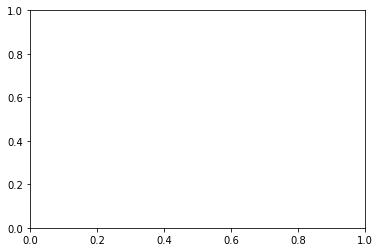

In [8]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(2, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, 7140)


    def forward(self, x):
        x1 = torch.sigmoid(self.fc1(x))
        x2 = torch.sigmoid(self.fc2(x1))
        x3 = torch.sigmoid(self.fc3(x2))
        return x3

batchsize = 


trainset = torch.utils.data.TensorDataset(dataset, labelset)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchsize,
                                          shuffle=True, num_workers=4)

net = Net()


import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.Adamax(net.parameters())

all_losses = []
for epoch in range(50):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, datas in enumerate(trainloader, 0):
        inputs, labels = datas

#         l = torch.from_numpy(np.asarray([label[i]])).float()
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(inputs.float())
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()
    all_losses.append(running_loss / batchsize)
    print('[%d, %5d] loss: %.3f' %
          (epoch + 1, i + 1, running_loss / batchsize))
    plt.plot(all_losses)
    plt.savefig("result.png")
    plt.cla()
    running_loss = 0.0
print('Finished Training')

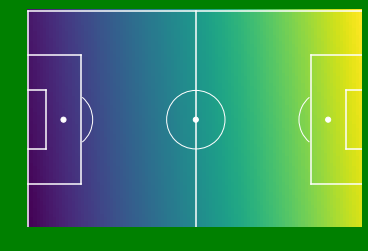

In [13]:
matrix = torch.load("matrix")
matrix = matrix / np.max(matrix)
plot_pitch()
plt.imshow(matrix)

In [99]:
np.shape(matrix)

(68, 105)

NameError: name 'net' is not defined

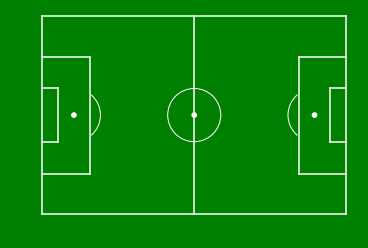

In [19]:
bx = 52
by = 34
plot_pitch()
plt.imshow(matrix+vector2matrix(net(torch.tensor([bx,by]).float()).detach()))
plt.scatter(bx,by,c='r')


In [109]:
for i in range(6):
    bx = 80
    by = [10*j for j in range(10)]
    plot_pitch()
    plt.imshow(matrix+vector2matrix(net(torch.tensor([bx,by[i]]).float()).detach()))
    plt.scatter(bx,by[i],c='r')
    plt.savefig("gif_Q/"+str(i)+'.png')
    plt.close()

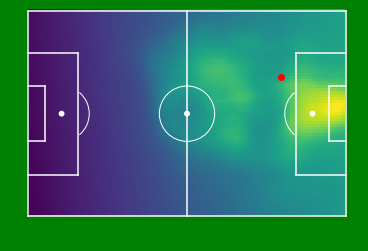

In [36]:
# net = Net()
bx,by = dataset[10]
plot_pitch()
plt.imshow(matrix+vector2matrix(net(torch.tensor([bx,by]).float()).detach()))
plt.scatter(bx,by,c='r')

In [20]:
def get_pc(playerX, playerY, ballX, ballY):
    matrices = []
    for index in range(len(playerX)):
        if index == 0:
            prex = playerX[index]
            prey = playerY[index]
        matrix = get_matrix(playerX[index],playerY[index],ballX[index], ballY[index], prex, prey)
        prex = playerX[index]
        prey = playerY[index]
        matrices.append(matrix)
    return matrices


sample_df = pd.read_csv('samples/6.0.csv')
sample_np = sample_df.values

ballX = 105-sample_np[:,49]
ballY = 68-sample_np[:,50]

direction = sample_np[0,48]

playerAX = 105-sample_np[:,12:23]
playerAY = 68-sample_np[:,34:45]

playerBX = 105- sample_np[:,1:12]
playerBY = 68-sample_np[:,23:34]

matrixA = get_pc(playerAX[:500], playerAY[:500], ballX[:500], ballY[:500])
matrixB = get_pc(playerBX[:500], playerBY[:500], ballX[:500], ballY[:500])



/usr/lib/python3/dist-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


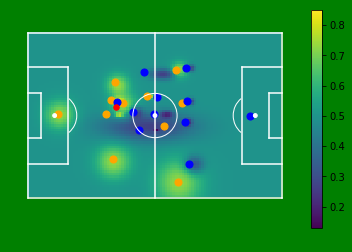

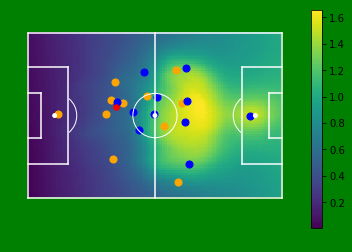

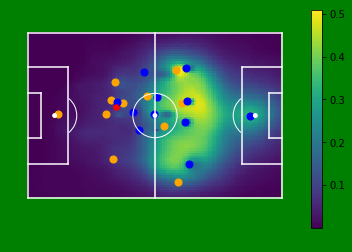

In [14]:
i=10
plot_pitch()
plt.imshow(torch.sigmoid(torch.tensor(matrixA[i]-matrixB[i])))
plt.colorbar()
plt.scatter(playerAX[i],playerAY[i],c='orange',s=50)
plt.scatter(playerBX[i],playerBY[i],c='blue',s=50)
plt.scatter(ballX[i],ballY[i],c='r',s=30)
plt.show()

plot_pitch()
plt.imshow(matrix+vector2matrix(net(torch.tensor([ballX[i],ballY[i]]).float()).detach()))
plt.colorbar()
plt.scatter(playerAX[i],playerAY[i],c='orange',s=50)
plt.scatter(playerBX[i],playerBY[i],c='blue',s=50)
plt.scatter(ballX[i],ballY[i],c='r',s=30)
plt.show()

plot_pitch()
Q=np.multiply(torch.sigmoid(torch.tensor(matrixA[i]-matrixB[i])),vector2matrix(net(torch.tensor([ballX[i],ballY[i]]).float()).detach()))
plt.imshow(Q)
plt.colorbar()
plt.scatter(playerAX[i],playerAY[i],c='orange',s=50)
plt.scatter(playerBX[i],playerBY[i],c='blue',s=50)
plt.scatter(ballX[i],ballY[i],c='r',s=30)
plt.show()

In [ ]:
for i in range(len(matrixA)):
    plot_pitch()
    Q=np.multiply(torch.sigmoid(torch.tensor(matrixA[i]-matrixB[i])),matrix+vector2matrix(net(torch.tensor([ballX[i],ballY[i]]).float()).detach()))
    plt.imshow(Q)
    plt.colorbar()
    plt.clim([0,1])
    plt.scatter(playerAX[i],playerAY[i],c='orange',s=50)
    plt.scatter(playerBX[i],playerBY[i],c='blue',s=50)
    plt.scatter(ballX[i],ballY[i],c='r',s=30)
    plt.savefig("gif_Qplayers/"+str(i)+'.png')
    plt.cla()

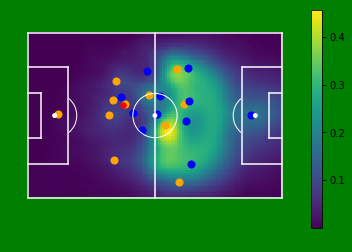

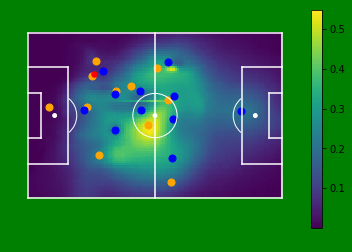

In [22]:
plot_pitch()
Q=np.multiply(torch.sigmoid(torch.tensor(matrixA[0]-matrixB[0])),vector2matrix(net(torch.tensor([ballX[0],ballY[0]]).float()).detach()))
plt.imshow(Q)
plt.colorbar()
plt.scatter(playerAX[0],playerAY[0],c='orange',s=50)
plt.scatter(playerBX[0],playerBY[0],c='blue',s=50)
plt.scatter(ballX[0],ballY[0],c='r',s=30)
plt.show()

i = 100
plot_pitch()
Q=np.multiply(torch.sigmoid(torch.tensor(matrixA[i]-matrixB[i])),vector2matrix(net(torch.tensor([ballX[i],ballY[i]]).float()).detach()))
plt.imshow(Q)
plt.colorbar()
plt.scatter(playerAX[i],playerAY[i],c='orange',s=50)
plt.scatter(playerBX[i],playerBY[i],c='blue',s=50)
plt.scatter(ballX[i],ballY[i],c='r',s=30)
plt.show()

In [50]:
df = pd.read_csv("Kashiwa1st_play.csv")
data = df[['時間','選手ID','F_パス','ボールＸ','ボールＹ','F_成功']]

pass_list = []
for i, row in data.iterrows():
    if row['F_パス']==1:
        pass_list.append([data.iloc[i].values,data.iloc[i+1].values])

In [129]:

for row in pass_list:
    bx = 105*(row[0][3]+157.5)/(157.5*2)-1
    by = 68*(row[0][4]+102)/(102*2)-1
    bx2 = 105*(row[1][3]+157.5)/(157.5*2)-1
    by2 = 68*(row[1][4]+102)/(102*2)-1
    Q1 = ((matrix+vector2matrix(net(torch.tensor([bx,by]).float()).detach()))[int(np.floor(by)),int(np.floor(bx))]).numpy()
    Q2 = ((matrix+vector2matrix(net(torch.tensor([bx,by]).float()).detach()))[int(np.floor(by2)),int(np.floor(bx2))]).numpy()
    print(row[0][1],Q1,row[1][1],Q2,row[0][5])

800926.0 0.7519347122218023 0.0 0.7519347122218023 1.0
1400783.0 0.5124200431588173 800926.0 1.4966344837400563 1.0
800926.0 0.9336965684148916 603420.0 1.3374881354624026 0.0
603420.0 0.9201106635385744 900052.0 0.4423757251325725 0.0
900052.0 0.45238784514104113 300133.0 1.3870173580878067 0.0
300133.0 0.7222617305748747 400745.0 0.3887512584724309 0.0
400745.0 0.48850180334829113 800926.0 1.4988954220097859 1.0
1300881.0 0.7587785649113868 800926.0 1.136742625058122 1.0
800926.0 0.8948595557813123 1200953.0 0.9479385168992638 0.0
1200953.0 0.904418394132769 603420.0 1.0317036946438645 1.0
603420.0 0.9838463515127018 400526.0 1.0452847375767096 1.0
400526.0 1.0488004940196807 900052.0 0.26902767287440604 0.0
900052.0 0.45698709802575416 1200043.0 0.2812273456799335 1.0
1200043.0 0.5387058585035152 1400738.0 1.427250645483392 1.0
1000106.0 0.6899347932486286 400526.0 0.8884533413136013 0.0
400526.0 0.9225952692711361 900128.0 0.831795449832204 0.0
900128.0 0.8983515757114917 400526.0 

1300103.0 0.5573173558348492 1300881.0 0.19996104007142224 0.0
900128.0 0.4270354196090952 900052.0 0.1829098730505913 1.0
900052.0 0.28982736237063106 800114.0 1.5076801801242872 0.0
800114.0 0.7204156393327756 1200043.0 0.25251202092616276 0.0
1200043.0 0.3056763804382089 1400783.0 0.3305043328333988 1.0
1400783.0 0.47191150281542404 800926.0 0.6713669396782951 1.0
800926.0 0.545320460915782 1400738.0 0.4730591236799465 1.0
1400738.0 0.6787252358889703 1400738.0 0.6488576049799646 1.0
1400738.0 0.5944147969479288 800926.0 0.6327009511137104 1.0
800926.0 0.5808962521100139 1400783.0 0.3774924857459601 1.0
1400783.0 0.4765382340356847 1000106.0 0.6743492297526599 1.0
1000106.0 0.5284188802804559 1400783.0 0.36315194172899923 1.0
1400783.0 0.49966305894892415 1200043.0 0.4077685849158994 1.0
1200043.0 0.5371174762725054 1000106.0 0.7327510667574872 1.0
1000106.0 0.5554104549420347 1200953.0 0.5673217328662177 0.0
1200953.0 0.7369766684645911 400526.0 0.6356196903926046 1.0
400526.0 0.64

900516.0 0.37028089138932085 1300103.0 0.32547361012314224 1.0
1300103.0 0.5573324954146222 1200043.0 0.12012436376520476 0.0
800126.0 0.27275311075820535 1300103.0 1.5547266940990685 0.0
1300103.0 0.8599583845058679 900128.0 0.7295113636377912 0.0
900128.0 0.9367900126185311 1201326.0 0.9142138650605204 1.0
1000106.0 0.9474251553005392 900516.0 1.5676914159019009 0.0
1000106.0 1.0015927796510855 800926.0 0.9312360097369473 1.0
800926.0 0.8967110547684486 1300103.0 1.7240317677416874 0.0
800926.0 0.800066664375853 1400738.0 0.9451369369114264 1.0
1400738.0 0.9317447243436022 900128.0 1.2035027476512665 1.0
900128.0 0.9770967694484468 1400738.0 0.9597684419798407 1.0
1400738.0 1.1961835956987281 1000106.0 1.2973935175404385 1.0
300133.0 1.3190776161174127 1200953.0 1.3196457087661853 1.0
1200953.0 1.1750941820005742 1400652.0 0.9587114665079772 1.0
1400652.0 0.8247609995551779 1200043.0 0.41635518914303893 0.0
1400783.0 0.5711536676930546 1400783.0 0.43258776312520203 1.0


In [123]:
68*(row[1][4]+102)/(102*2)

68.66666666666667

In [75]:
[int(by),int(bx)]

[61, 79]